In [2]:
import os, joblib
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns


In [3]:
def get_dicts(path, prefix, regr_ts, rand_ts):
    rand_dict = joblib.load(f"{path}/{prefix}_{rand_ts}_RANDOM_FINAL.jbl")
    regr_dict = joblib.load(f"{path}/{prefix}_{regr_ts}.jbl")
    return regr_dict, rand_dict

path = "/Users/orenkobo/Desktop/PhD/Aim1/Aim1/OutputsAnalyser/ZZZ_notebooks/" \
       "Notebooks__For_Paper/Trained_models/"
lstm_cond_embed_dict_prefix = "LSTM_cond_embed_output_object"
regr_ts = "1649259787.042902"
rand_ts = "1649356410.032912"

regr_dict, rand_dict = get_dicts(path, lstm_cond_embed_dict_prefix, regr_ts, rand_ts)

In [4]:
print(regr_dict['details'])
print(regr_dict['res_dict'][5].keys())

LSTM + cond embed, 500 iters, 80/10/10 split
dict_keys(['eval', 'test_subjects', 'test_pred', 'test_true', 'per_subject_mean_pred', 'per_subject_mean_label', 'per_subject_is_success', 'subj_level_acc'])


In [5]:
from pylab import *
import scipy.stats
from palettable.colorbrewer.qualitative import Set2_7

def draw_stars_box(regr_acc_l, rand_acc_l):
    #https://github.com/jbmouret/matplotlib_for_papers
    fig = figure()
    ax = fig.add_subplot(111)
    bp = ax.boxplot([regr_acc_l, rand_acc_l])
    params = {
        'axes.labelsize': 8,
        'font.size': 8,
        'legend.fontsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'text.usetex': False,
        'figure.figsize': [5, 8]
    }
    rcParams.update(params)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x', direction='out', size=15)
    ax.tick_params(axis='y', length=0)
    ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    # colors, as before
    colors = Set2_7.mpl_colors

    for i in range(0, len(bp['boxes'])):
        bp['boxes'][i].set_color(colors[i])
        # we have two whiskers!
        bp['whiskers'][i*2].set_color(colors[i])
        bp['whiskers'][i*2 + 1].set_color(colors[i])
        bp['whiskers'][i*2].set_linewidth(2)
        bp['whiskers'][i*2 + 1].set_linewidth(2)
        # fliers
        # (set allows us to set many parameters at once)
        bp['fliers'][i].set(markerfacecolor=colors[i],
                            marker='o', alpha=0.75, markersize=6,
                            markeredgecolor='none')
        bp['medians'][i].set_color('black')
        bp['medians'][i].set_linewidth(3)
        # and 4 caps to remove
        for c in bp['caps']:
            c.set_linewidth(0)
    for i in range(len(bp['boxes'])):
        box = bp['boxes'][i]
        box.set_linewidth(0)
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
            boxCoords = list(zip(boxX,boxY))
            boxPolygon = Polygon(boxCoords, facecolor = colors[i], linewidth=0)
            ax.add_patch(boxPolygon)
    ax.set_xticklabels(['Actual','Shuffled'], fontsize=15)


    def stars(p):
        if p < 0.0001:
            return "****"
        elif (p < 0.001):
            return "***"
        elif (p < 0.01):
            return "**"
        elif (p < 0.05):
            return "*"
        else:
            return "-"


    z, p = scipy.stats.mannwhitneyu(regr_acc_l, rand_acc_l)

    p_value = p * 2
    s = stars(p)
    y_max = np.max(np.concatenate((regr_acc_l, rand_acc_l)))
    y_min = np.min(np.concatenate((regr_acc_l, rand_acc_l)))

    ax.annotate("", xy=(1, y_max), xycoords='data',
                xytext=(2, y_max), textcoords='data',
                arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                                connectionstyle="bar,fraction=0.2"))
    ax.text(1.5, y_max + abs(y_max - y_min)*0.1, stars(p_value),
            horizontalalignment='center',
            verticalalignment='center')
    plt.suptitle("Per iteration accuracy ", fontsize = 16)
    fig.subplots_adjust(left=0.2)

    plt.show()

def compare_dict(regr_dict, rand_dict, n_iters = 500):
    plt.rcParams.update({'font.size': 14})
    regr_acc_l = [regr_dict['res_dict'][x]['subj_level_acc'] for x in range(n_iters)]
    rand_acc_l = [rand_dict['res_dict'][x]['subj_level_acc'] for x in range(n_iters)]
    sns.distplot(regr_acc_l, color = 'b',bins= 10, hist_kws={ "alpha": 0.1});
    sns.distplot(rand_acc_l, color = 'r',bins= 10, hist_kws={ "alpha": 0.1});
    plt.title("Per iteration accuracy", fontsize=17);
    plt.legend(['Actual','Shuffled'], fontsize=15)
    plt.xlabel("Accuracy", fontsize=15);
    plt.ylabel("Percent", fontsize=15);

    plt.show()

    plt.boxplot([regr_acc_l, rand_acc_l]);
    plt.xticks(ticks = [1,2], labels = ["Actual","Shuffled"],fontsize=14);
    plt.title("LSTM with condition embedding layer");
    plt.show()

    res_df = pd.DataFrame(columns = ["Actual","Shuffled"])
    res_df["Actual"] = regr_acc_l
    res_df["Shuffled"] = rand_acc_l
    res_df["Iter_num"] = res_df.index
    melted_res_df = pd.melt(res_df, id_vars = 'Iter_num', value_name = "acc", var_name = "iter_type");
    sns.relplot(x="Iter_num", y="acc", hue="iter_type", kind="line", data=melted_res_df);
    plt.show()

    draw_stars_box(regr_acc_l, rand_acc_l)

In [8]:
regr_acc_l = [regr_dict['res_dict'][x]['subj_level_acc'] for x in range(500)]
rand_acc_l = [rand_dict['res_dict'][x]['subj_level_acc'] for x in range(500)]
print(np.mean(regr_acc_l), np.std(regr_acc_l))
print(np.mean(rand_acc_l), np.std(rand_acc_l))

0.6327999999999999 0.13915516519339122
0.4528 0.1432904742123495


/Users/orenkobo/Desktop/PhD/Aim1/Aim1/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/orenkobo/Desktop/PhD/Aim1/Aim1/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


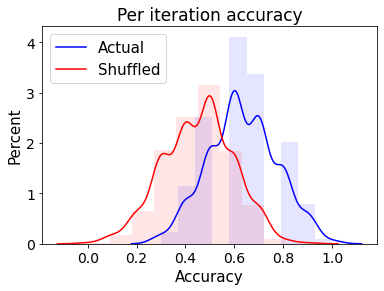

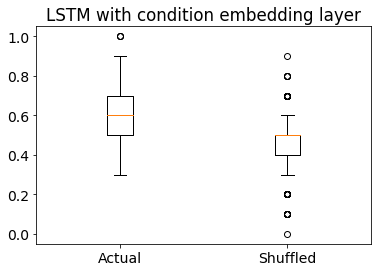

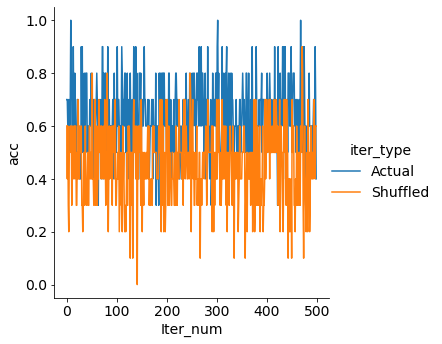

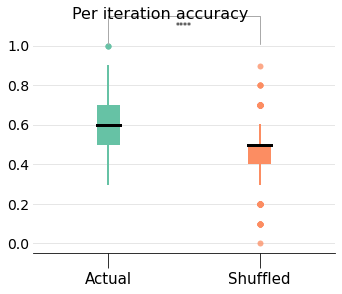

In [9]:
compare_dict(regr_dict, rand_dict)